In [17]:
# Importing libraries
import time, psutil, os, math
from tqdm.contrib import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from sklearn.model_selection import train_test_split

# import function from notebook
from ipynb.fs.full.logreg import grad_desc, logistic

In [2]:
# Runtime and memory usage
start = time.time()
process = psutil.Process(os.getpid())

In [3]:
# Loading the data
data = pd.read_csv('training.zip')
print(pd.Series({"Memory usage": "{:.4f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

Memory usage       62.9426 MB
Dataset shape    (250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


# Preprocessing

1. Data cleaning (dropping off unused and inconsistent columns)
2. Splitting data into train and test
3. Splitting datasets into features and target.
4. Normalize data to ensure all columns expressed in the similar scale.

In [4]:
# Dropping unnecessary columns
data.drop(['EventId', 'Weight'], axis = 1, inplace = True)

# Replacing -999 with nan
data.replace(to_replace = -999, value = np.nan, inplace = True)

# Encoding the 'Label' column
label_dict = {'b': 0, 's': 1}
data.replace({'Label': label_dict}, inplace = True)

In [5]:
# Train-test split
data_train, data_test = train_test_split(data, test_size = 0.2, random_state = 40)

In [6]:
# Columns with missing values with respective proportions
(data.isna().sum()[data.isna().sum() > 0] / len(data)).sort_values(ascending = False)

DER_deltaeta_jet_jet      0.709828
DER_mass_jet_jet          0.709828
DER_prodeta_jet_jet       0.709828
DER_lep_eta_centrality    0.709828
PRI_jet_subleading_pt     0.709828
PRI_jet_subleading_eta    0.709828
PRI_jet_subleading_phi    0.709828
PRI_jet_leading_pt        0.399652
PRI_jet_leading_eta       0.399652
PRI_jet_leading_phi       0.399652
DER_mass_MMC              0.152456
dtype: float64

In [7]:
# Discarding columns with more than 30% missing data
cols_missing_drop = [
    'DER_deltaeta_jet_jet',
    'DER_mass_jet_jet',
    'DER_prodeta_jet_jet',
    'DER_lep_eta_centrality',
    'PRI_jet_subleading_pt',
    'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi',
    'PRI_jet_leading_pt',
    'PRI_jet_leading_eta',
    'PRI_jet_leading_phi'
]
data_train.drop(cols_missing_drop, axis = 1, inplace = True)
data_test.drop(cols_missing_drop, axis = 1, inplace = True)

# Median imputation
data_train['DER_mass_MMC'].fillna(data_train['DER_mass_MMC'].median(), inplace = True)
data_test['DER_mass_MMC'].fillna(data_test['DER_mass_MMC'].median(), inplace = True)

In [8]:
# Features-target split
X_train, y_train = data_train.drop('Label', axis = 1), data_train['Label']
X_test, y_test = data_test.drop('Label', axis = 1), data_test['Label']

In [9]:
# Min-Max normalization
for col in X_train.columns:
    if (X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64') and X_train[col].nunique() > 1:
        X_train[col] = (X_train[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min())
for col in X_test.columns:
    if (X_test[col].dtypes == 'int64' or X_test[col].dtypes == 'float64') and X_test[col].nunique() > 1:
        X_test[col] = (X_test[col] - X_test[col].min()) / (X_test[col].max() - X_test[col].min())

# Model Fitting

In [10]:
# Initial values of the model parameters
w_init = np.array([-5, -15, -10, 9, 4, -6, 3, -10, 1, 14, 0, 0, 15, 0, 0, 7, 0, -3, 1, -8]).astype(float)
b_init = -1.

# Learning model parameters using gradient descent algorithm
w_out, b_out, cost_history, params_history = grad_desc(X_train.to_numpy(),
                                                       y_train.to_numpy(),
                                                       w = w_init, # np.zeros(X_train.shape[1]),
                                                       b = b_init, # 0,
                                                       alpha = 0.1,
                                                       n_iter = 500)

  0%|          | 0/500 [00:00<?, ?it/s]

Iteration      0:    Cost  0.5279
Iteration     50:    Cost  0.5258
Iteration    100:    Cost  0.5255
Iteration    150:    Cost  0.5253
Iteration    200:    Cost  0.5251
Iteration    250:    Cost  0.5250
Iteration    300:    Cost  0.5250
Iteration    350:    Cost  0.5249
Iteration    400:    Cost  0.5249
Iteration    450:    Cost  0.5248
Iteration    499:    Cost  0.5248


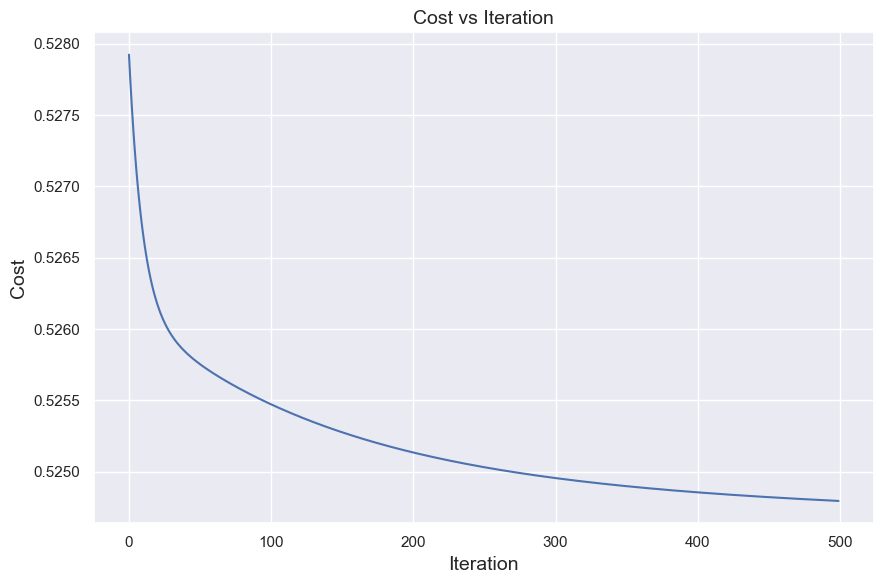

In [11]:
# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

In [12]:
# Final parameter values
params_history[-1]

[array([-4.98663802e+00, -1.49893547e+01, -1.00137118e+01,  9.00126321e+00,
         4.07988477e+00, -6.00355089e+00,  3.00338681e+00, -1.00243896e+01,
         8.03705519e-01,  1.40044095e+01, -1.33894132e-02, -3.69298260e-03,
         1.49857524e+01, -1.05902510e-02,  5.40126800e-03,  7.00889938e+00,
         1.07459138e-02, -3.00072134e+00,  8.74589508e-01, -7.99360503e+00]),
 -1.0158158666502208]

# Prediction and Evaluation

First, we construct some functions to compute and display the *confusion matrix*, and to compute *accuracy*, given the true labels and the predicted labels of the target.

In [13]:
# Function to compute confusion matrix
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat

In [14]:
# Function to print confusion matrix
def conf_mat_heatmap(y_test, y_pred):
    """
    Prints confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

In [15]:
# Function to compute accuracy
def accuracy(y_test, y_pred):
    """
    Computes accuracy, given true and predicted binary (0 or 1) labels
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      acc (float): accuracy obtained from y_test and y_pred
    """
    confusion_mat = conf_mat(y_test, y_pred)
    num = confusion_mat[0, 0] + confusion_mat[1, 1] # Number of correct predictions
    denom = num + confusion_mat[0, 1] + confusion_mat[1, 0] # Number of total predictions
    acc = num / denom
    return acc

In [18]:
# Prediction and evaluation on the training set and the test set
y_train_prob = logistic(np.matmul(X_train.to_numpy(), w_out) + (b_out * np.ones(X_train.shape[0])))
y_test_prob = logistic(np.matmul(X_test.to_numpy(), w_out) + (b_out * np.ones(X_test.shape[0])))
y_train_pred, y_test_pred = (y_train_prob > 0.5).astype(int), (y_test_prob > 0.5).astype(int)
print(pd.Series({"Training accuracy": accuracy(y_train, y_train_pred),
                 "Test accuracy": accuracy(y_test, y_test_pred)}).to_string())

Training accuracy    0.72653
Test accuracy        0.71922


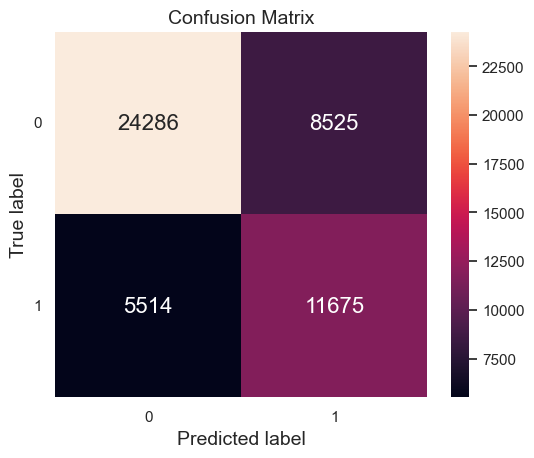

In [19]:
# Confusion matrix for predictions on the test set
conf_mat_heatmap(y_test, y_test_pred)